<a href="https://colab.research.google.com/github/Cepeda-R/Data-Science/blob/master/TorqueFailurePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ETL (Extract Transform & Load) Data

**OBJECTIVE: PREDICTIVE MAINTENANCE (FAILURE RATE)**

    Machine Predictive Maintenance Classification Dataset

    Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

    The dataset consists of 10 000 data points stored as rows with 14 features in columns

    UID: unique identifier ranging from 1 to 10000
    productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
    air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
    process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
    rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
    torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
    tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
    'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.


In other words - WITH the set of parameters it's needed to identified the Target (which are 2) - Failure or Failure Type

In [2]:
#general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date

#statistics
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm 
import pylab as py 

#misc
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config IPCompleter.greedy=True

In [3]:
machinedata_raw = pd.read_csv('/content/drive/MyDrive/Citeve_PumpDataset/predictive_maintenance.csv')
machinedata_raw.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
machinedata_raw.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [5]:
len(machinedata_raw)

10000

In [6]:
machinedata_raw.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

No Null Values observed, however that doesn't mean that some columns could be through some analysis/changes

In [7]:
machinedata_raw['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [8]:
machinedata_raw['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [9]:
temp_a = machinedata_raw.query('Target == 1')
temp_b = machinedata_raw.query('Target == 0')

In [10]:
temp_a['Target'].value_counts()[1]/temp_b['Target'].value_counts()[0]*100


3.508953524479867

ASSUMPTION: 3.5% of the data have a failure 
If it is decided to descriminate by type of failure, the model could provide with unrealiable data since it has few datapoints

**However, failure type %wise will be saved to propose in flask API

In [11]:
value_counts = machinedata_raw['Failure Type'].value_counts(dropna=True, sort=True)

# solution here
value_counts = pd.DataFrame(value_counts)
value_counts_reset = value_counts.reset_index()
value_counts_reset.columns = ['unique_values', 'counts'] # change column names
value_counts_reset = value_counts_reset.iloc[1:] #remove first line
value_counts_reset['cumulative'] = value_counts_reset['counts'].cumsum()/value_counts_reset['counts'].sum()*100
value_counts_reset['percentwise'] = value_counts_reset['counts']/value_counts_reset['counts'].sum()*100

In [12]:
value_counts_reset.head()

,unique_values,counts,cumulative,percentwise
1,Heat Dissipation Failure,112,32.183908,32.183908
2,Power Failure,95,59.482759,27.298851
3,Overstrain Failure,78,81.896552,22.413793
4,Tool Wear Failure,45,94.827586,12.931034
5,Random Failures,18,100.000000,5.172414


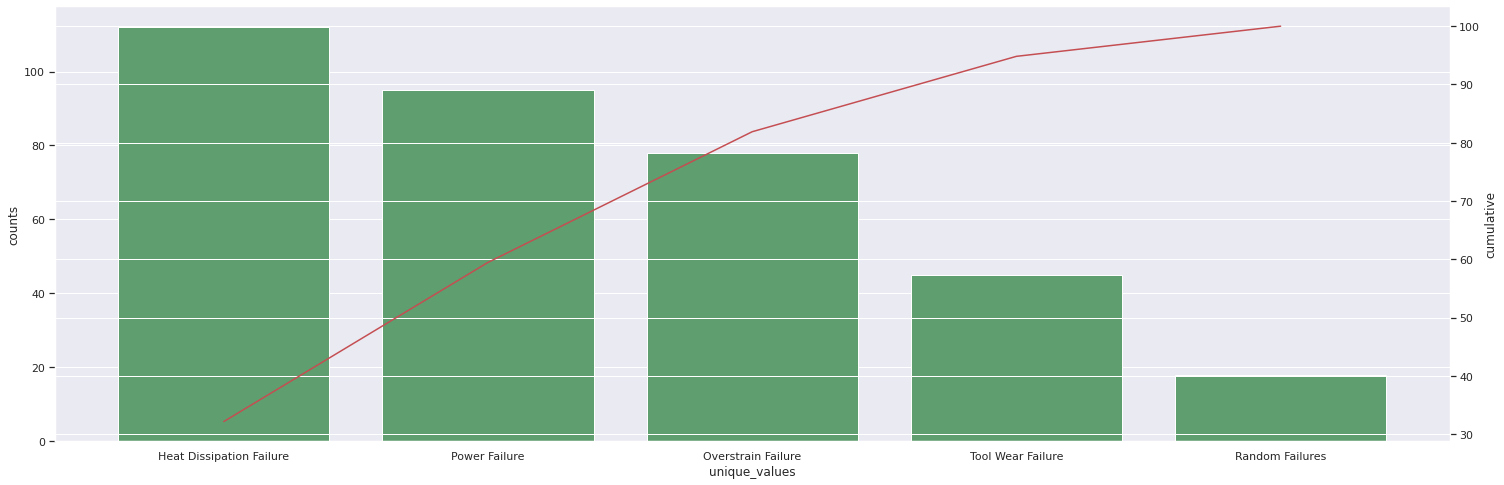

In [13]:
sns.set(rc={'figure.figsize':(25,8)})
sns.barplot(data=value_counts_reset,x=value_counts_reset['unique_values'], y=value_counts_reset['counts'], color="g")
ax2 = plt.twinx()
sns.lineplot(data=value_counts_reset, x=value_counts_reset['unique_values'], y=value_counts_reset['cumulative'], color="r", ax=ax2)

Failure Type will be eliminated for ML Model since the script already have percentage wise data above

In [14]:
machinedata_raw.drop('Failure Type', axis=1, inplace=True)

Product ID & UID column will be eliminated since is redundant to type of quality L M and H

In [15]:
machinedata_raw.drop('UDI', axis=1, inplace=True)
machinedata_raw.drop('Product ID', axis=1, inplace=True)

Need to create a time reference column to compare data throughout time

In [16]:
machinedata_raw['prod_time [min]'] = machinedata_raw['Tool wear [min]'].cumsum()

In [17]:
machinedata_raw.tail()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,prod_time [min]
9995,M,298.8,308.4,1604,29.5,14,0,1079416
9996,H,298.9,308.4,1632,31.8,17,0,1079433
9997,M,299.0,308.6,1645,33.4,22,0,1079455
9998,H,299.0,308.7,1408,48.5,25,0,1079480
9999,M,299.0,308.7,1500,40.2,30,0,1079510


Analysing at the tail of the table, max prod_time [min] gives us the timeframe of data Collection: 2 Years

Looking at the table - tool wear in minutes is reseted after a tool wear break (failure)

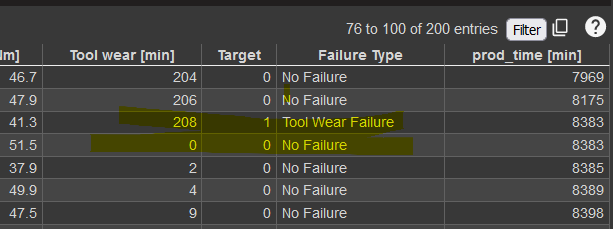

I could transform Kelvin to Celsius, however this project is Machine comunicating with Predictive Model. So kelvin data enters directly into the model + kelvin has an higher scale than celsius so its values could provide with more weight

In [18]:
#machinedata_raw.drop('rotspeed_boxcox', axis=1, inplace=True)

# Explore Data Analysis EDA

Understand ToolWear vs. Failure

1st Chart - Data throughout time with fails as ticks

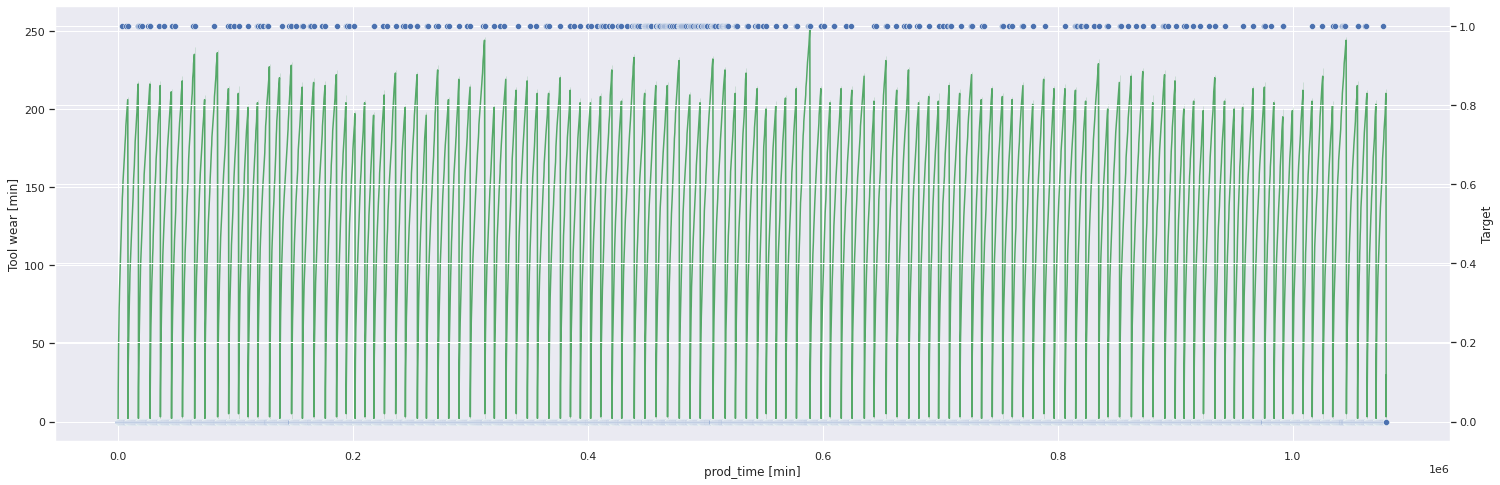

In [19]:
sns.set(rc={'figure.figsize':(25,8)})
sns.lineplot(data=machinedata_raw, x='prod_time [min]', y='Tool wear [min]', color="g")
ax2 = plt.twinx()
sns.scatterplot(data=machinedata_raw, x='prod_time [min]', y='Target', color="b", ax=ax2)

Failure Mode its not only time base because it is seen variation between failures throughout time (for example, between 0.4 and 0.6 failure rate is bigger than the of the time)

In other words, exist other factors that can impact failure rate

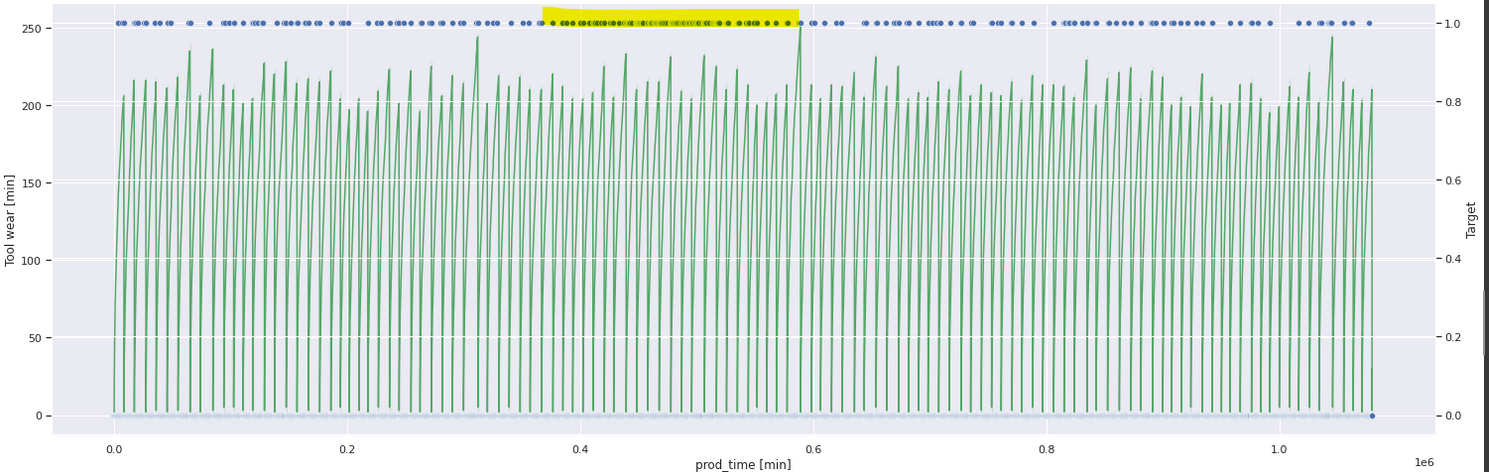

Before conduction a correlation matrix, lets first dive into data normality in non-timebase related parameters



1.   Air temperature [K] 	
2.   Process temperature [K] 	
3.   Rotational speed [rpm] 	
4.   Torque [Nm]



In [20]:
from scipy.stats import shapiro

In [21]:
shapiro(machinedata_raw['Torque [Nm]'])

ShapiroResult(statistic=0.9997753500938416, pvalue=0.38203656673431396)

In [22]:
shapiro(machinedata_raw['Rotational speed [rpm]'])

ShapiroResult(statistic=0.8645210862159729, pvalue=0.0)

In [23]:
shapiro(machinedata_raw['Air temperature [K]'])

ShapiroResult(statistic=0.9807608723640442, pvalue=1.3204146667681844e-34)

In [24]:
shapiro(machinedata_raw['Process temperature [K]'])

ShapiroResult(statistic=0.9923496842384338, pvalue=9.738203885027511e-23)

Why we have non normal data in 3 features. Lets check on Correlation matrix

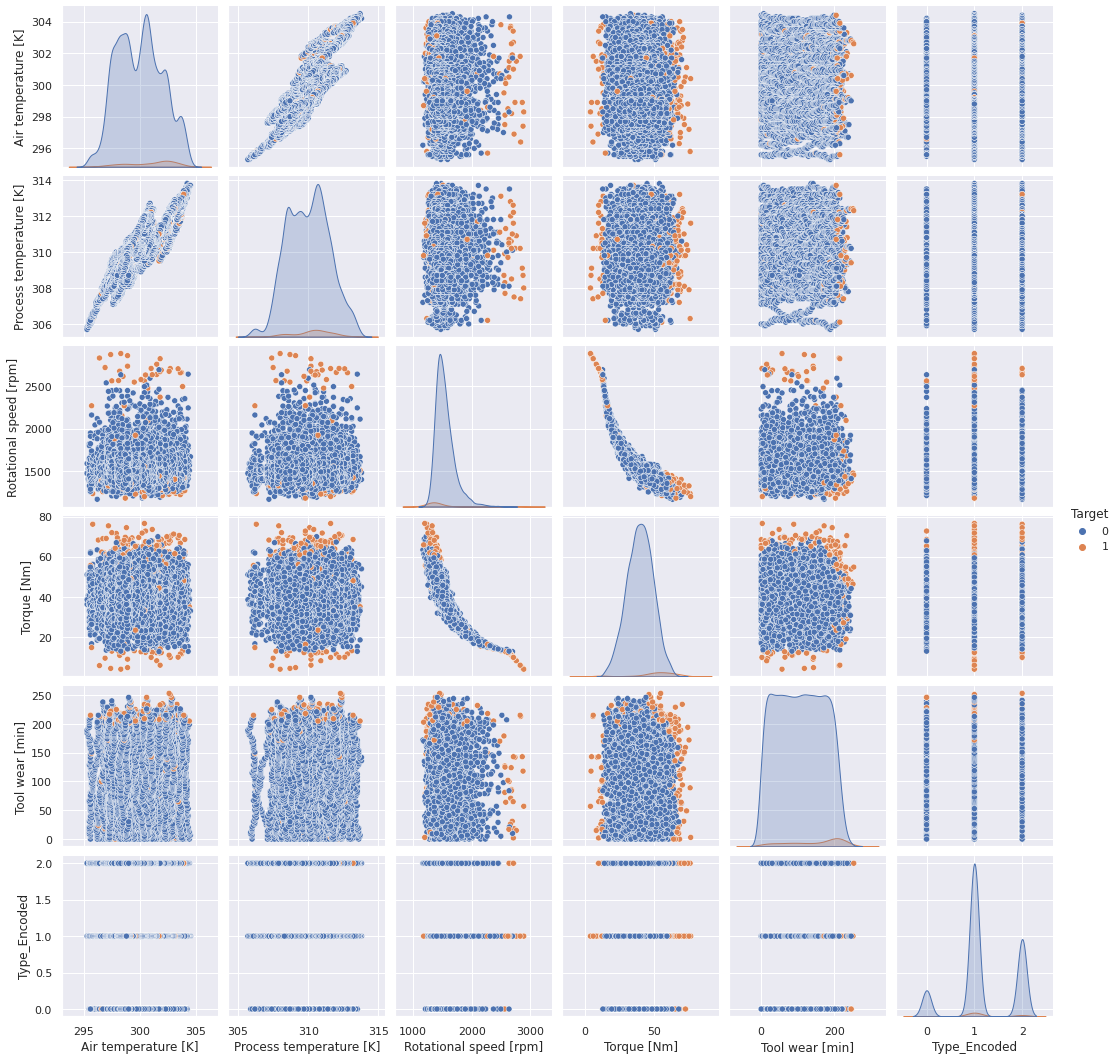

In [144]:
sns.pairplot(data=machinedata_raw, hue="Target")



1.   Air temperature and Process temperature don't have normal distribution. this can be explained due to controlled temperature modules and product type influence
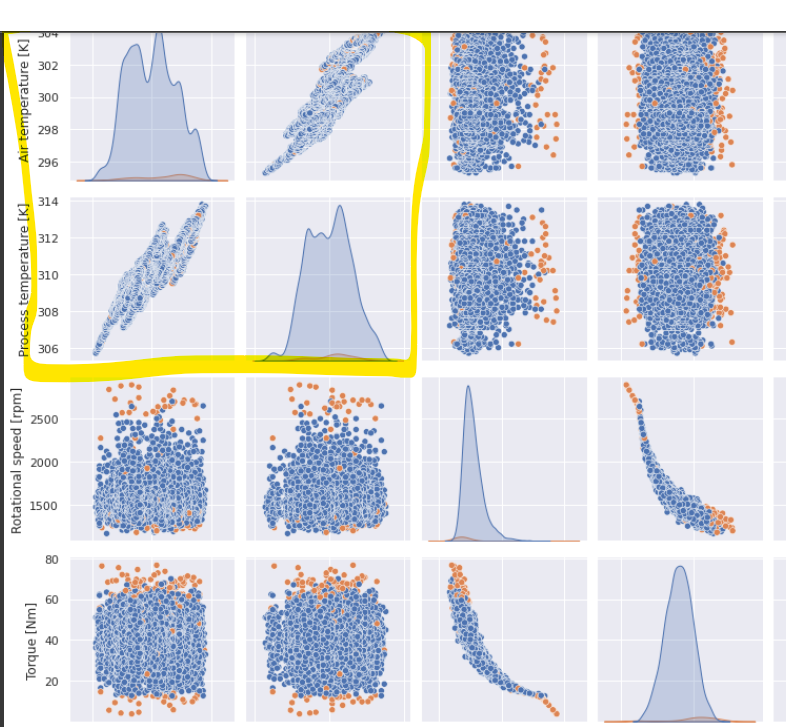
2.   Torque and Speed are correlated between one to another. Correlation statistics must be done. However, since rotation speed is not normal, we need to transform this variable into normal in order to compare with torque and have an higher correlation
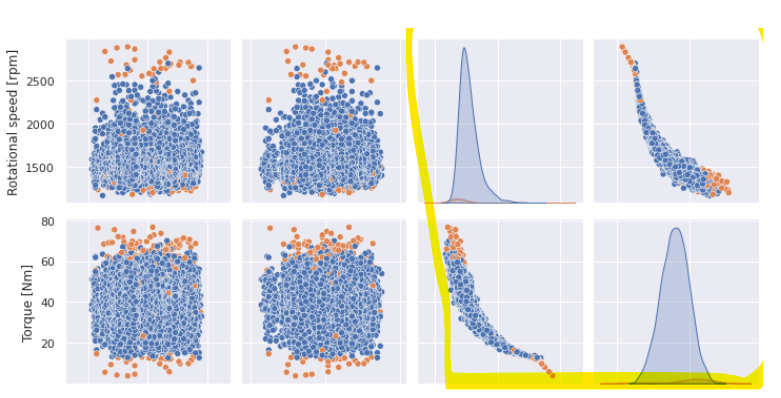
3.   From all of the matrix we can validate that failures occurred in the max, min of every feature. In other words, when the machine exceeds a threshold level it can create a failure



Torque and Speed will be evaluated throughout spearman corr

In [26]:
from scipy.stats import spearmanr

In [27]:
# calculate spearman's correlation
corr, _ = spearmanr(machinedata_raw['Torque [Nm]'], machinedata_raw['Rotational speed [rpm]'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.916


In [28]:
machinedata_raw['rotspeed_boxcox'],parameters=stats.boxcox(machinedata_raw['Rotational speed [rpm]'])

In [29]:
corr, _ = spearmanr(machinedata_raw['Torque [Nm]'], machinedata_raw['rotspeed_boxcox'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: -0.916


In [30]:
shapiro(machinedata_raw['rotspeed_boxcox'])

ShapiroResult(statistic=1.0, pvalue=1.0)

this new column created rotspeed_boxcox have the same correlation. So normal distribution transformation is not needed

In [31]:
machinedata_raw.drop('rotspeed_boxcox', axis=1, inplace=True)

In [146]:
machinedata_raw.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Type_Encoded
0,298.1,308.6,1551,42.8,0,0,2
1,298.2,308.7,1408,46.3,3,0,1
2,298.1,308.5,1498,49.4,5,0,1
3,298.2,308.6,1433,39.5,7,0,1
4,298.2,308.7,1408,40.0,9,0,1


KeyError: ignored

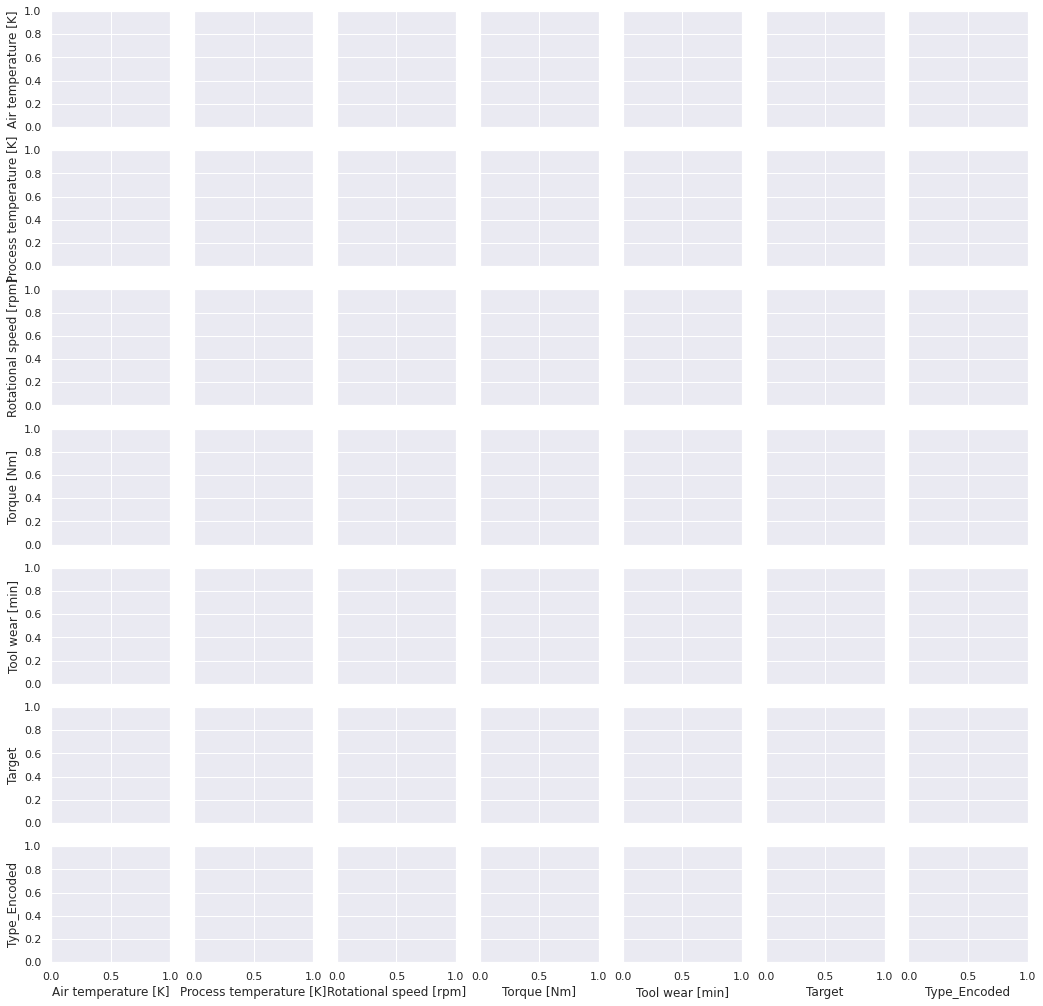

In [145]:
sns.pairplot(data=machinedata_raw, hue="Type")

It is seen and verified that Quality takes a major influence. Higher Quality Products exhibits features with lower parameters such as torque, speed and even temperature. This means that Higher quality is defined by controlled parameters (with a lower threshold)

Lets Prove it Using Violin Chart

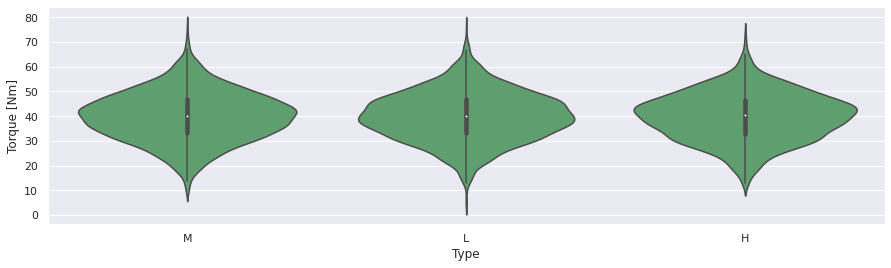

In [34]:
sns.set(rc={'figure.figsize':(15,4)})
sns.violinplot(data=machinedata_raw, x='Type', y='Torque [Nm]', color="g")
#sns.violinplot(x='Type 1', y='Attack', data=df)
#ax2 = plt.twinx()
#sns.scatterplot(data=machinedata_raw, x='prod_time [min]', y='Target', color="b", ax=ax

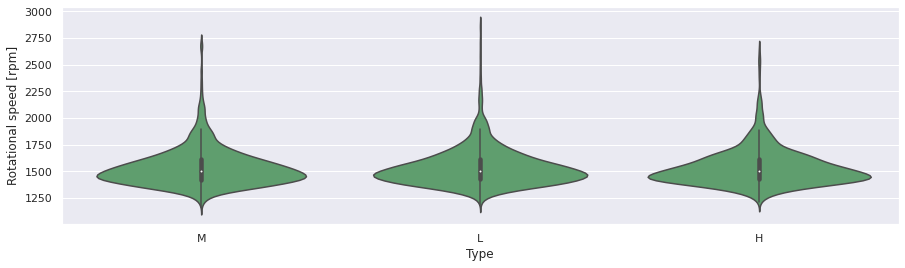

In [35]:
sns.set(rc={'figure.figsize':(15,4)})
sns.violinplot(data=machinedata_raw, x='Type', y='Rotational speed [rpm]', color="g")
#sns.violinplot(x='Type 1', y='Attack', data=df)
#ax2 = plt.twinx()
#sns.scatterplot(data=machinedata_raw, x='prod_time [min]', y='Target', color="b", ax=ax

Lets Understand Failure Level vs. Type of Product (Quality Wise)

In [36]:
machinedata_raw['Target'].value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [37]:
value_counts_tempa = temp_a['Type'].value_counts(dropna=True, sort=True)

# solution here
value_counts_tempa = pd.DataFrame(value_counts_tempa)
value_counts_tempa_reset = value_counts_tempa.reset_index()
value_counts_tempa_reset.columns = ['unique_values', 'counts'] # change column names
#value_counts_reset['cumulative'] = value_counts_reset['counts'].cumsum()/value_counts_reset['counts'].sum()*100
#value_counts_reset['percentwise'] = value_counts_reset['counts']/value_counts_reset['counts'].sum()*100

In [39]:
value_counts_tempa_reset

,unique_values,counts
0,L,235
1,M,83
2,H,21


This is not enough - Volume of type of products varies, so it cannot be compared solely by counts

In [50]:
weight_type = [0.5, 0.3, 0.2]
weight_type = pd.DataFrame(weight_type)
weight_type_reset = weight_type.reset_index()
weight_type_reset.columns = ['unique_values', 'counts']

In [56]:
value_counts_tempa_reset['ppm_level'] = value_counts_tempa_reset['counts']*weight_type_reset['counts']

In [57]:
value_counts_tempa_reset

,unique_values,counts,ppm_level
0,L,235,117.5
1,M,83,24.9
2,H,21,10.5


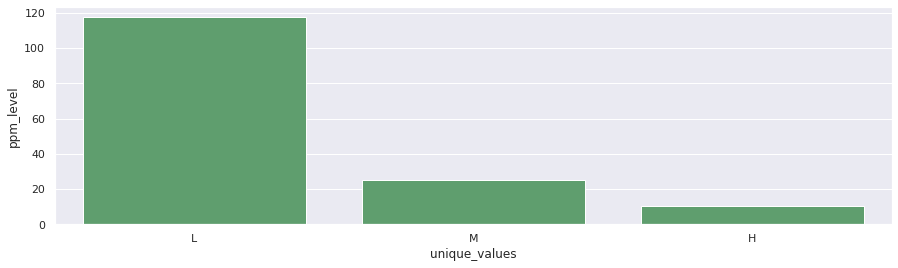

In [59]:
sns.set(rc={'figure.figsize':(15,4)})
sns.barplot(data=value_counts_tempa_reset , x='unique_values', y='ppm_level', color="g")
#sns.violinplot(x='Type 1', y='Attack', data=df)
#ax2 = plt.twinx()
#sns.scatterplot(data=machinedata_raw, x='prod_time [min]', y='Target', color="b", ax=ax

Project Summary

1.   Quality takes a major influence into the Machine Performance. Higher Quality Products exhibits features with tighter parameters such as torque, speed and even temperature. Additionaly Higher Quality Products have fewer breakdown events
2.   From all of the matrix we can validate that failures occurred in the max, min of every feature. In other words, when the machine exceeds a threshold level it can create a failure
3.   Rotational Speed & Torque have a high correlation using spearman corr. A column was created to increase this correlation since Rotational Speed don't follow a normal distribution (it was used boxcox transformation). However the correlation results were the same - column should not be used
4.   Failure Mode doesn't occurr only time base because it is seen variation between failures throughout time (for example, between 0.4 and 0.6t failure rate is higher) + creating a time reference this database was created with a timespan of 2 years
5.   Tool wear [min] is reseted after a tool wear break (failure)
6.   All columns will be used for Training. Prod Time will be used as well since it can correlate with other type of failures and not toolbit wear


# Train Test Split ML Model

In [68]:
machinedata = machinedata_raw

In [69]:
machinedata.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,prod_time [min]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,5.417754e+05
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,3.121896e+05
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000e+00
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,2.717372e+05
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,5.443605e+05
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,8.129392e+05
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.079510e+06


In [90]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestRegressor 


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

First and Foremost, it is needed to encode labels in Type

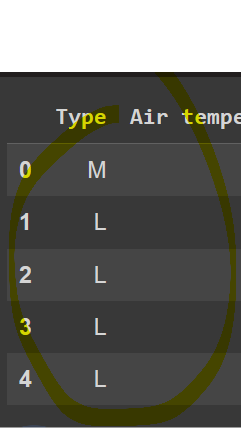

In [78]:
remove_encoder = ['H', 'L', 'M']
q_encoder = preprocessing.LabelEncoder()
q_encoder.fit(machinedata['Type'])
machinedata['Type_Encoded'] = q_encoder.transform(machinedata['Type'])

In [80]:
machinedata.head(5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,prod_time [min],Type_Encoded
0,M,298.1,308.6,1551,42.8,0,0,0,2
1,L,298.2,308.7,1408,46.3,3,0,3,1
2,L,298.1,308.5,1498,49.4,5,0,8,1
3,L,298.2,308.6,1433,39.5,7,0,15,1
4,L,298.2,308.7,1408,40.0,9,0,24,1


Labels must be removed since machine learning models don't use strings as training and only numbers 



To train the model, it is needed to split target value from features values

In [99]:
machinedata.drop('prod_time [min]', axis=1, inplace=True)

In [81]:
machinedata.drop('Type', axis=1, inplace=True)
x = machinedata.drop(['Target'], axis = 1)
y = machinedata['Target']

In [100]:
x_train, x_test, y_train, y_test = train_test_split ( x, y , test_size=0.4, random_state=42)

In [112]:
#Calling Machine Learning Algorithm
svc_model = LinearSVC()

#Training
svc_model.fit(x_train, y_train)

#Prediction for Test
y_pred_svc = svc_model.predict(x_test)

#Results Data
print(accuracy_score(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test,y_pred_svc))

0.96775
[[3871    0]
 [ 129    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3871
           1       0.00      0.00      0.00       129

    accuracy                           0.97      4000
   macro avg       0.48      0.50      0.49      4000
weighted avg       0.94      0.97      0.95      4000



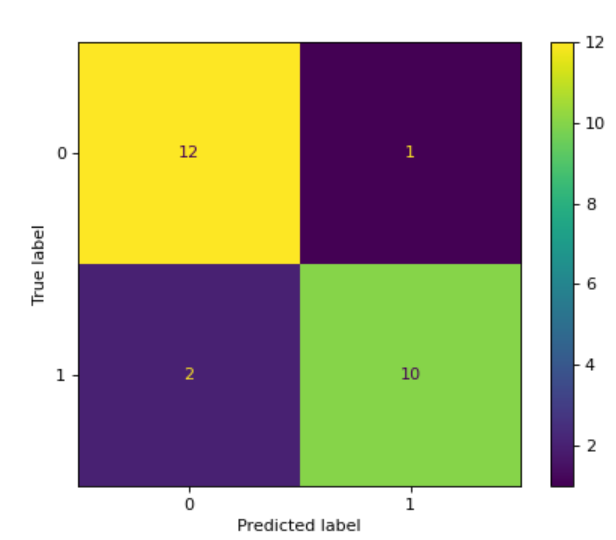

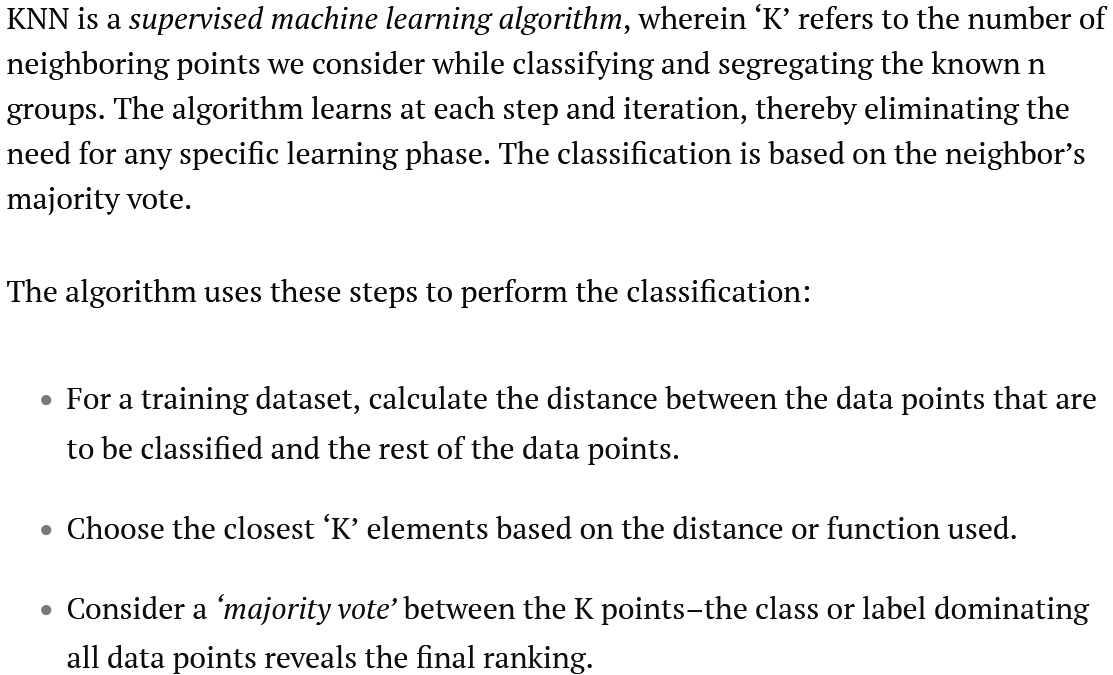

In [109]:
#Calling Machine Learning Algorithm
kneighbors_model = KNeighborsClassifier(n_neighbors=2)

#Training
kneighbors_model.fit(x_train, y_train)

#Prediction for Test
y_pred_kneighbors = kneighbors_model.predict(x_test)

#Results Data
print(accuracy_score(y_test, y_pred_kneighbors))
print(confusion_matrix(y_test, y_pred_kneighbors))
print(classification_report(y_test,y_pred_kneighbors))

0.965
[[3859   12]
 [ 128    1]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3871
           1       0.08      0.01      0.01       129

    accuracy                           0.96      4000
   macro avg       0.52      0.50      0.50      4000
weighted avg       0.94      0.96      0.95      4000



Using Confusion Matrix it is shown that failures are not detected. Keep in mind that project is to detect failures 

Increase Data with Failures will increase the weight of Target

In [126]:
temp_c = machinedata.query('Target == 1')
temp_d = machinedata.query('Target == 1')
temp_e = machinedata.query('Target == 1')

In [128]:
frames = [temp_c, temp_d, temp_e]

In [129]:
result = pd.concat(frames)

In [130]:
frames_new = [result, machinedata]

In [131]:
machinedata_synt = pd.concat(frames_new)

In [132]:
x = machinedata_synt.drop(['Target'], axis = 1)
y = machinedata_synt['Target']

In [133]:
x_train, x_test, y_train, y_test = train_test_split ( x, y , test_size=0.4, random_state=42)

In [134]:
#Calling Machine Learning Algorithm
kneighbors_model = KNeighborsClassifier()

#Training
kneighbors_model.fit(x_train, y_train)

#Prediction for Test
y_pred_kneighbors = kneighbors_model.predict(x_test)

#Results Data
print(accuracy_score(y_test, y_pred_kneighbors))
print(confusion_matrix(y_test, y_pred_kneighbors))
print(classification_report(y_test,y_pred_kneighbors))

0.9142273655547992
[[3654  189]
 [ 189  375]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3843
           1       0.66      0.66      0.66       564

    accuracy                           0.91      4407
   macro avg       0.81      0.81      0.81      4407
weighted avg       0.91      0.91      0.91      4407



Lets do a grid search. Apply a range of different parameters into the model to test all possibilities

In [136]:
# define the parameter values that should be searched
k_range = list(range(1, 31))

# default options --> uniform (all points in the neighborhood are weighted equally)
# another option --> distance (weights closer neighbors more heavily than further neighbors)
weight_options = ['uniform', 'distance']

In [137]:
# create a parameter grid: map the parameter names to the values that should be searched
# dictionary = dict(key=values, key=values)
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


cv means cross validation. Use various blocks of the data (same size) to test the model. Reduce accuracy but the model returns closer to reality

In [139]:
grid = GridSearchCV(kneighbors_model, param_grid, cv=10, scoring='accuracy')
grid.fit(x, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [140]:
# view the complete results
print(grid.best_score_)
print(grid.best_params_)

0.9807578822090461
{'n_neighbors': 30, 'weights': 'distance'}


In [143]:
#Calling Machine Learning Algorithm
kneighbors_model = KNeighborsClassifier(n_neighbors = 30, weights = 'distance')

#Training
kneighbors_model.fit(x_train, y_train)

#Prediction for Test
y_pred_kneighbors = kneighbors_model.predict(x_test)

#Results Data
print(accuracy_score(y_test, y_pred_kneighbors))
print(confusion_matrix(y_test, y_pred_kneighbors))
print(classification_report(y_test,y_pred_kneighbors))

0.9782164737916951
[[3779   64]
 [  32  532]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3843
           1       0.89      0.94      0.92       564

    accuracy                           0.98      4407
   macro avg       0.94      0.96      0.95      4407
weighted avg       0.98      0.98      0.98      4407



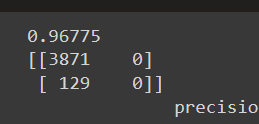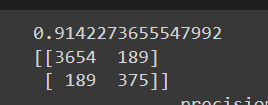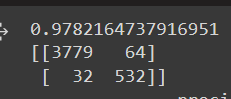

1.  Training Model wasn't detecting the Failures as seen from the first picture above
2.  Triplicate the failure values into train database in order to have more impact
3.  Use Search Grid to have the best parameters and achieved 89% of accuracy related to failures

## Save & Load the Model

Save the model with the best performance

In [155]:
import joblib

In [159]:
joblib.dump(kneighbors_model, '/content/drive/MyDrive/Citeve_PumpDataset/machinefailure.pkl.pkl')

['/content/drive/MyDrive/Citeve_PumpDataset/machinefailure.pkl.pkl']

In [161]:
knn_from_joblib = joblib.load('/content/drive/MyDrive/Citeve_PumpDataset/machinefailure.pkl.pkl')

In [162]:
print(knn_from_joblib.predict(x_test))

[1 0 0 ... 0 0 1]
